In [18]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of sumie.sumie failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ValueError: __init__() requires a code object with 0 free vars, not 1
]


In [19]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/sumie"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/sumie


In [0]:
import sumie.inputs
import sumie.sumie
import sumie.transforms
import sumie.objectives
import sumie.montage

In [21]:
model = torchvision.models.vgg16(pretrained=True).eval()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
def denormalise(in_tensor):
    mean = torch.as_tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.as_tensor([0.229, 0.224, 0.225]).to(device)
    return in_tensor * std[None,:,None,None] + mean[None,:,None,None]
 
def normalise(in_tensor):
    mean = torch.as_tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.as_tensor([0.229, 0.224, 0.225]).to(device)
    return (in_tensor - mean[None,:,None,None]) / std[None,:,None,None]

tensor(-0.2375, device='cuda:0', grad_fn=<NegBackward>)
tensor(-31.2998, device='cuda:0', grad_fn=<NegBackward>)
tensor(-55.1884, device='cuda:0', grad_fn=<NegBackward>)
tensor(-81.4932, device='cuda:0', grad_fn=<NegBackward>)
tensor(-102.2044, device='cuda:0', grad_fn=<NegBackward>)
tensor(-118.1610, device='cuda:0', grad_fn=<NegBackward>)
tensor(-126.1382, device='cuda:0', grad_fn=<NegBackward>)
tensor(-138.4129, device='cuda:0', grad_fn=<NegBackward>)
tensor(-152.1606, device='cuda:0', grad_fn=<NegBackward>)
tensor(-151.8063, device='cuda:0', grad_fn=<NegBackward>)


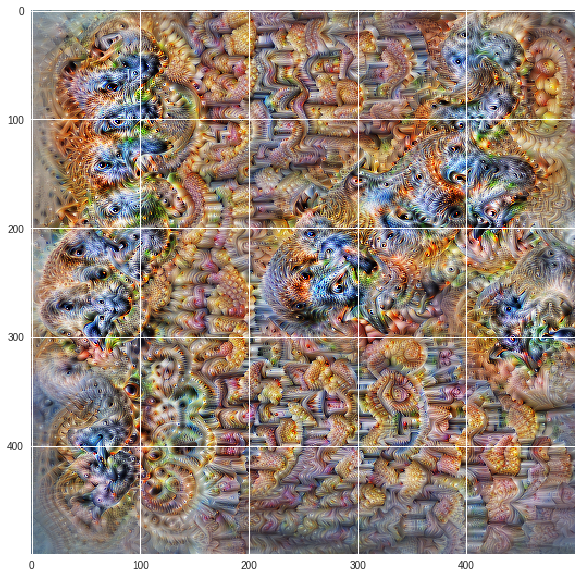

In [34]:
im = sumie.sumie.Image(600, transforms=
              [sumie.transforms.PositionJitter(8),
              sumie.transforms.RandomCrop((500,500))]
            )

device = 'cuda'
im.to(device)
model.to(device)
optimiser = torch.optim.Adam(im.parameters(), lr=0.05)
steps = 100
channel = sumie.objectives.ConvChannel(model.features[28], 11, func=torch.std)
#channel = objectives.Linear(model.fc, 102)
for i in range(steps):
    optimiser.zero_grad()
    input_image = im()
    #input_image = torch.nn.functional.interpolate(input_image,
    #                                              scale_factor=0.25,
    #                                              mode='bilinear')
    out = model.features(normalise(input_image))
    
    loss = -channel.objective
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    optimiser.step()

fig = plt.figure(figsize=(10,10))
sumie.montage.show(255*im().cpu())

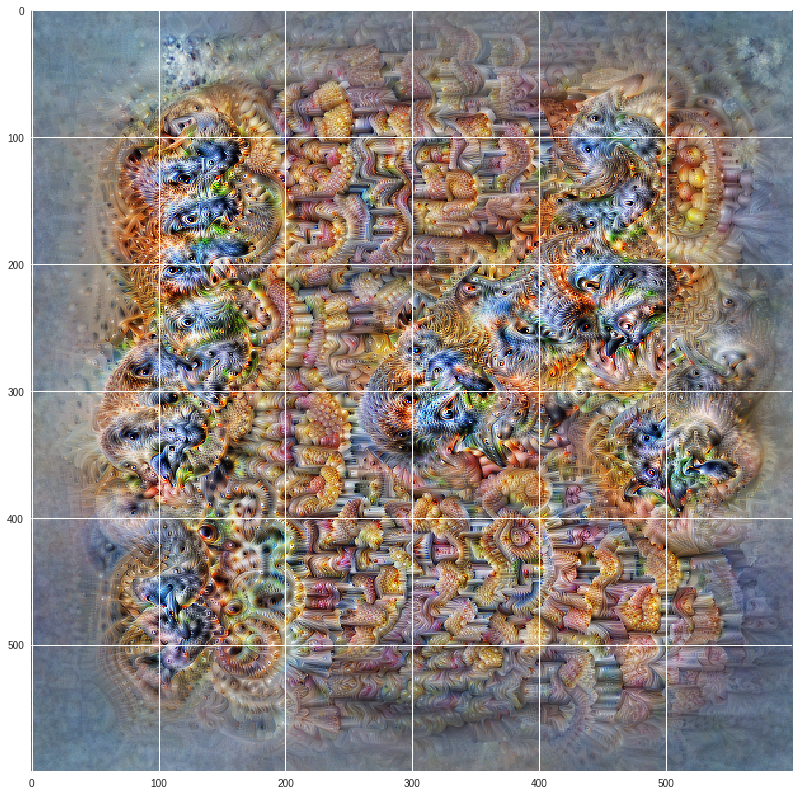

In [35]:
fig = plt.figure(figsize=(14,14))
sumie.montage.show(255*im.get_image().cpu())